In [345]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Data Preparation

In [346]:
df = pd.read_csv('SpotMe_data.csv')
df.head()

,user_id,purchase_time,spotme_purchase_amount,funding_time,funding_amount
0,22070,2/26/19 19:39,7.53,3/7/19 10:07,438.54
1,22070,2/27/19 0:00,3.95,3/7/19 10:07,438.54
2,22151,1/2/19 0:53,8.49,1/9/19 17:42,810.36
3,22151,1/3/19 4:36,2.00,1/9/19 17:42,810.36
4,22151,1/14/19 14:24,16.31,1/14/19 15:54,91.00


In [347]:
# df.sort_values(by=["user_id","funding_time","purchase_time"],inplace=True)
df['funding_time'] = pd.to_datetime(df['funding_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])
df.dtypes
df.head(5)

,user_id,purchase_time,spotme_purchase_amount,funding_time,funding_amount
0,22070,2019-02-26 19:39:00,7.53,2019-03-07 10:07:00,438.54
1,22070,2019-02-27 00:00:00,3.95,2019-03-07 10:07:00,438.54
2,22151,2019-01-02 00:53:00,8.49,2019-01-09 17:42:00,810.36
3,22151,2019-01-03 04:36:00,2.00,2019-01-09 17:42:00,810.36
4,22151,2019-01-14 14:24:00,16.31,2019-01-14 15:54:00,91.00


In [348]:
# check invalid rows
invalid_rows = df[df['purchase_time'] > df['funding_time']]
print(invalid_rows)

Empty DataFrame
Columns: [user_id, purchase_time, spotme_purchase_amount, funding_time, funding_amount]
Index: []


### Feature Engineering

In [349]:
# add calculated field
df['repayment_time_days'] = (df['funding_time'] - df['purchase_time']).dt.days
df['repayment_time_days'] = (df['funding_time'] - df['purchase_time']).dt.total_seconds() / (24 * 3600)
df['repayment_time_days'] = df['repayment_time_days'].round(1)
df['total_spotme_before_funding'] = df.groupby(['user_id','funding_amount'])['spotme_purchase_amount'].cumsum()

In [296]:
df['balance_after_funding'] = 0.0
for user in df['user_id'].unique():
    user_data = df[df['user_id'] == user].sort_values(by='purchase_time')
    for funding_time in user_data['funding_time'].unique():
        balance = 0
        user_funding_time_data = user_data[user_data['funding_time']==funding_time].sort_values(by='purchase_time')
        for index, row in user_funding_time_data.iterrows():
            balance += row['spotme_purchase_amount']
            balance -= row['funding_amount']
            df.loc[index, 'balance_after_funding'] = balance

In [297]:
df['spotme_usage'] = df.groupby('user_id').cumcount() + 1

In [350]:
df['spotme_usage_amount'] = df.groupby('user_id')['spotme_purchase_amount'].cumsum()
# df.sort_values(by=["user_id","funding_time","purchase_time"],inplace=True)
df['total_spotme_usage_times'] = df.groupby('user_id')['purchase_time'].count()
df.head(5)

,user_id,purchase_time,spotme_purchase_amount,funding_time,funding_amount,repayment_time_days,total_spotme_before_funding,spotme_usage_amount,total_spotme_usage_times
0,22070,2019-02-26 19:39:00,7.53,2019-03-07 10:07:00,438.54,8.6,7.53,7.53,NaN
1,22070,2019-02-27 00:00:00,3.95,2019-03-07 10:07:00,438.54,8.4,11.48,11.48,NaN
2,22151,2019-01-02 00:53:00,8.49,2019-01-09 17:42:00,810.36,7.7,8.49,8.49,NaN
3,22151,2019-01-03 04:36:00,2.00,2019-01-09 17:42:00,810.36,6.5,10.49,10.49,NaN
4,22151,2019-01-14 14:24:00,16.31,2019-01-14 15:54:00,91.00,0.1,16.31,26.80,NaN


### Exploratory Data Analysis

In [351]:
# Statistics"
df_exp = df.copy()
df_exp.describe()

,user_id,spotme_purchase_amount,funding_amount,repayment_time_days,total_spotme_before_funding,spotme_usage_amount,total_spotme_usage_times
count,34992.000000,34992.000000,34752.000000,34752.000000,34752.000000,34992.000000,2848.000000
mean,32949.565015,6.674787,554.189328,3.999885,12.751416,51.137154,8.065660
std,24280.717963,5.355371,904.755678,8.852063,9.416580,50.604491,7.627265
min,201.000000,0.010000,0.010000,0.000000,0.010000,0.010000,1.000000
25%,15257.750000,2.110000,63.282500,0.700000,6.080000,18.210000,3.000000
50%,21120.000000,5.250000,336.260000,2.000000,12.480000,36.965000,6.000000
75%,47429.000000,9.990000,720.292500,5.100000,18.010000,67.942500,11.000000
max,99913.000000,25.000000,19089.200000,229.700000,198.410000,585.840000,77.000000


In [246]:
# Time Series
df_exp.set_index('purchase_time', inplace=True)
weekly_spotme_usage = df_exp.resample('W').agg({
    'spotme_purchase_amount': ['count', 'sum'],
    'user_id': ['count']
})
weekly_spotme_usage.columns = ['spotme_count', 'spotme_total_amount', 'user_id_count']
weekly_spotme_usage.reset_index(inplace=True)

df_exp.set_index('funding_time', inplace=True)
weekly_funding = df_exp.resample('W').agg({'funding_amount': ['count', 'sum']})
weekly_funding.columns = ['funding_count', 'funding_total_amount']
weekly_funding.reset_index(inplace=True)

In [252]:
df_exp.round(1).to_csv('df_exp.csv')

### Correlation Analysis

In [352]:
df_corr = df.copy()


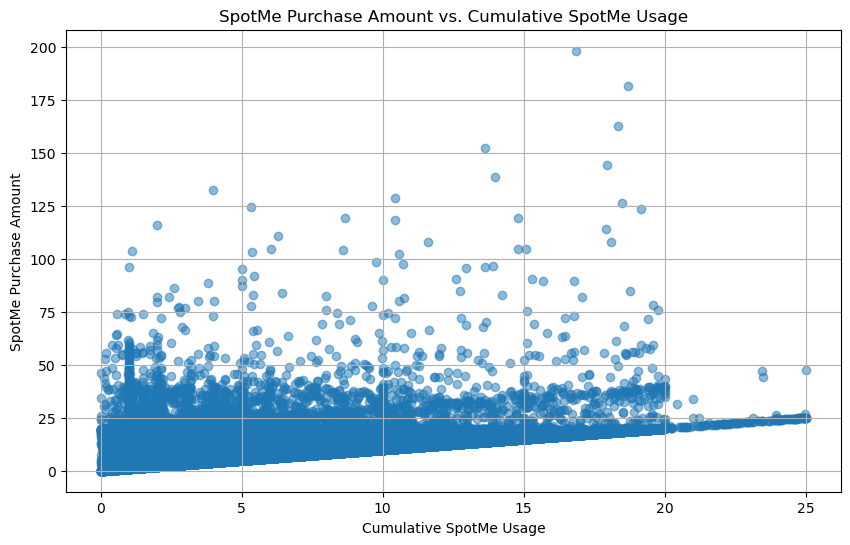

In [232]:
plt.figure(figsize=(10, 6))
plt.scatter(x='spotme_purchase_amount', y='total_spotme_before_funding', data=df_corr,alpha=0.5)
plt.title('SpotMe Purchase Amount vs. Cumulative SpotMe Usage')
plt.xlabel('Cumulative SpotMe Usage')
plt.ylabel('SpotMe Purchase Amount')
plt.grid(True)
plt.show()

In [353]:
correlation_coefficient = df_corr['funding_amount'].corr(df_corr['total_spotme_before_funding'])

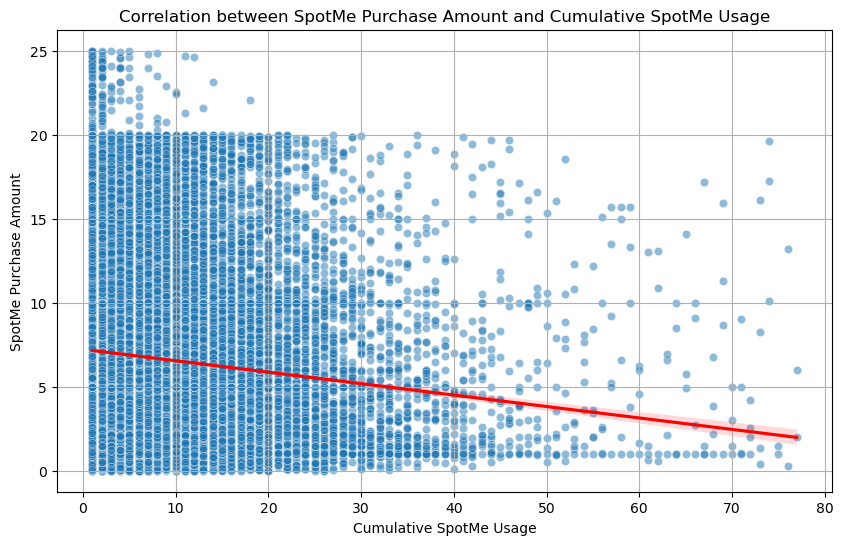

In [77]:
# Convert relevant columns to datetime
df['purchase_time'] = pd.to_datetime(df['purchase_time'])
df['funding_time'] = pd.to_datetime(df['funding_time'])

# Calculate repayment time in days as a float with one decimal place
df['repayment_time_days'] = (df['funding_time'] - df['purchase_time']).dt.total_seconds() / (24 * 3600)
df['repayment_time_days'] = df['repayment_time_days'].round(1)

# Calculate total_spotme_amount_before_funding
df['total_spotme_amount_before_funding'] = df.groupby('user_id')['spotme_purchase_amount'].cumsum()

# Initialize a new column for outstanding balance
df['outstanding_balance'] = 0.0

# Calculate outstanding balance for each user
for user in df['user_id'].unique():
    user_data = df[df['user_id'] == user].sort_values(by='purchase_time')
    outstanding_balance = 0
    for index, row in user_data.iterrows():
        outstanding_balance += row['spotme_purchase_amount']
        outstanding_balance -= row['funding_amount']
        df.loc[index, 'outstanding_balance'] = outstanding_balance

# Calculate cumulative_spotme_usage
df['cumulative_spotme_usage'] = df.groupby('user_id').cumcount() + 1

# Plot the correlation between SpotMe Purchase Amount and Cumulative SpotMe Usage
plt.figure(figsize=(10, 6))
sns.scatterplot(x='cumulative_spotme_usage', y='spotme_purchase_amount', data=df, alpha=0.5)
sns.regplot(x='cumulative_spotme_usage', y='spotme_purchase_amount', data=df, scatter=False, color='red')
plt.title('Correlation between SpotMe Purchase Amount and Cumulative SpotMe Usage')
plt.xlabel('Cumulative SpotMe Usage')
plt.ylabel('SpotMe Purchase Amount')
plt.grid(True)
plt.show()

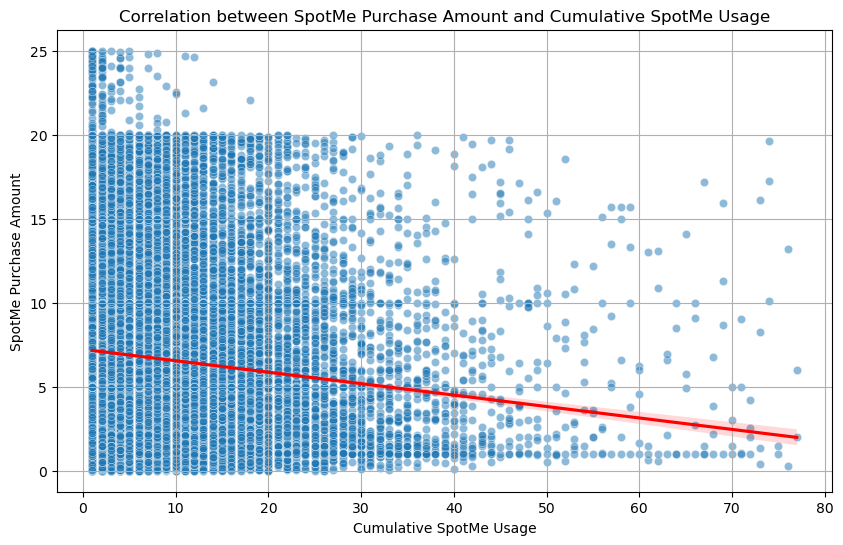

Pearson correlation coefficient: -0.10


In [78]:
# Convert relevant columns to datetime
df['purchase_time'] = pd.to_datetime(df['purchase_time'])
df['funding_time'] = pd.to_datetime(df['funding_time'])

# Calculate repayment time in days as a float with one decimal place
df['repayment_time_days'] = (df['funding_time'] - df['purchase_time']).dt.total_seconds() / (24 * 3600)
df['repayment_time_days'] = df['repayment_time_days'].round(1)

# Calculate total_spotme_amount_before_funding
df['total_spotme_amount_before_funding'] = df.groupby('user_id')['spotme_purchase_amount'].cumsum()

# Initialize a new column for outstanding balance
df['outstanding_balance'] = 0.0

# Calculate outstanding balance for each user
for user in df['user_id'].unique():
    user_data = df[df['user_id'] == user].sort_values(by='purchase_time')
    outstanding_balance = 0
    for index, row in user_data.iterrows():
        outstanding_balance += row['spotme_purchase_amount']
        outstanding_balance -= row['funding_amount']
        df.loc[index, 'outstanding_balance'] = outstanding_balance

# Calculate cumulative_spotme_usage
df['cumulative_spotme_usage'] = df.groupby('user_id').cumcount() + 1

# Plot the correlation
plt.figure(figsize=(10, 6))
sns.scatterplot(x='cumulative_spotme_usage', y='spotme_purchase_amount', data=df, alpha=0.5)
sns.regplot(x='cumulative_spotme_usage', y='spotme_purchase_amount', data=df, scatter=False, color='red')
plt.title('Correlation between SpotMe Purchase Amount and Cumulative SpotMe Usage')
plt.xlabel('Cumulative SpotMe Usage')
plt.ylabel('SpotMe Purchase Amount')
plt.grid(True)
plt.show()
correlation_coefficient = df['cumulative_spotme_usage'].corr(df['spotme_purchase_amount'])
print(f'Pearson correlation coefficient: {correlation_coefficient:.2f}')

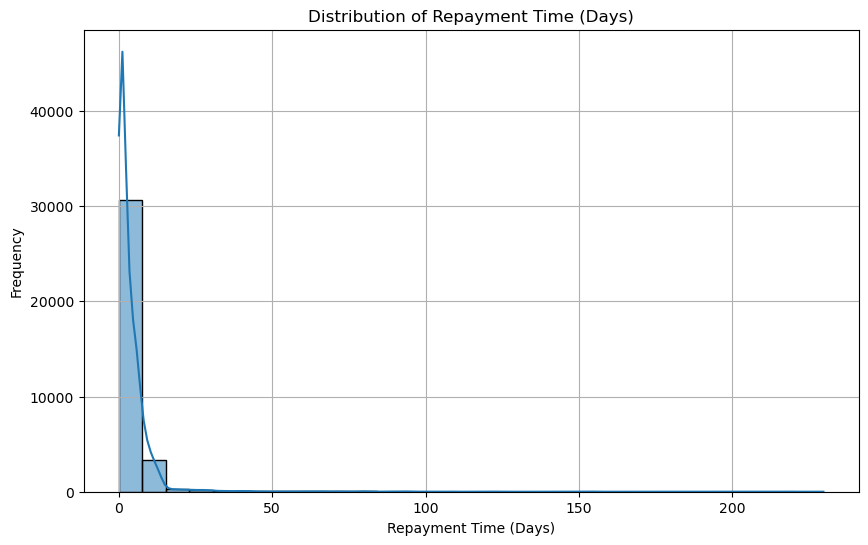

count    34752.0
mean         4.0
std          8.9
min          0.0
25%          0.7
50%          2.0
75%          5.1
max        229.7
Name: repayment_time_days, dtype: float64


In [80]:
df['purchase_time'] = pd.to_datetime(df['purchase_time'])
df['funding_time'] = pd.to_datetime(df['funding_time'])

# Calculate repayment time in days as a float with one decimal place
df['repayment_time_days'] = (df['funding_time'] - df['purchase_time']).dt.total_seconds() / (24 * 3600)
df['repayment_time_days'] = df['repayment_time_days'].round(1)

# Visualize the distribution of repayment times
plt.figure(figsize=(10, 6))
sns.histplot(df['repayment_time_days'], bins=30, kde=True)
plt.title('Distribution of Repayment Time (Days)')
plt.xlabel('Repayment Time (Days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Summary statistics for repayment time
repayment_time_summary = df['repayment_time_days'].describe().round(1)
print(repayment_time_summary)

In [339]:
df_corr.to_csv('df_corr.csv')

### Risk Analysis

In [96]:
df_risk = df.copy()

In [333]:
# there are three aspects we considered for risk score
# repayment time days : 60%
# outstanding balance :20%
# cumulative spotme usage: 20%

5.1
-822.0124999999999
11.0


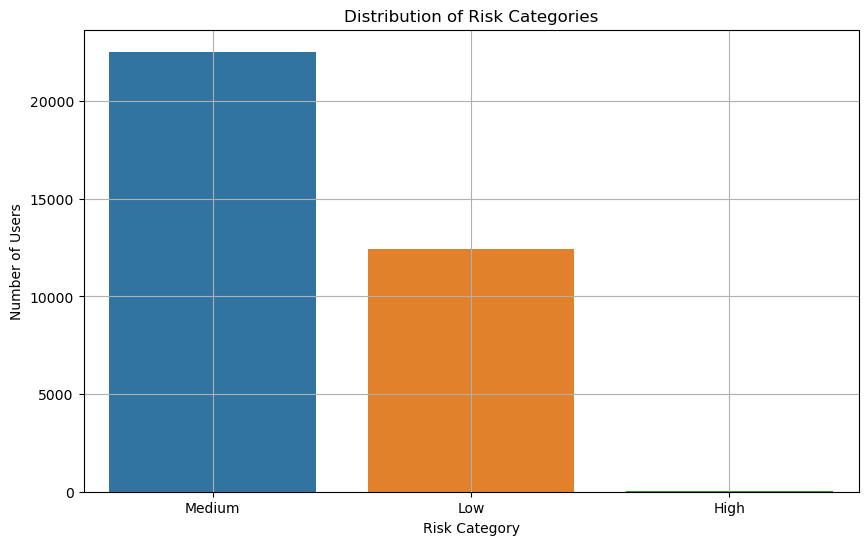

Medium    22532
Low       12438
High         22
Name: risk_category, dtype: int64


In [335]:
# calculate balance by users
df_risk['balance'] = df_risk.groupby('user_id')['spotme_purchase_amount'].cumsum() - df_risk.groupby('user_id')['funding_amount'].cumsum()

# Define thresholds for risk level (top 25%, 50% or 75%?)
repayment_time_threshold = df_risk['repayment_time_days'].quantile(0.75)
outstanding_balance_threshold = df_risk['outstanding_balance'].quantile(0.75)
usage_frequency_threshold = df_risk['cumulative_spotme_usage'].quantile(0.75)

print(repayment_time_threshold)
print(outstanding_balance_threshold)
print(usage_frequency_threshold)
# risk score with 75% percentile
df_risk['repayment_time_risk'] = (df_risk['repayment_time_days'] >= repayment_time_threshold).astype(int)
df_risk['outstanding_balance_risk'] = (df_risk['outstanding_balance'] >= outstanding_balance_threshold).astype(int)
df_risk['usage_frequency_risk'] = (df_risk['cumulative_spotme_usage'] >= usage_frequency_threshold).astype(int)

# Define weights
weights = {
    'repayment_time_risk': 0.6,
    'outstanding_balance_risk': 0.2,
    'usage_frequency_risk': 0.2
}

# Calculate the overall score by applying the weights
df_risk['overall_score'] = (df_risk['repayment_time_risk'] * weights['repayment_time_risk'] +
                            df_risk['outstanding_balance_risk'] * weights['outstanding_balance_risk'] +
                            df_risk['usage_frequency_risk'] * weights['usage_frequency_risk'])


# risk categories
def categorize_risk(score):
    if score == 0:
        return 'Low'
    elif score <= 2:
        return 'Medium'
    else:
        return 'High'

df_risk['risk_category'] = df_risk['composite_risk_score'].apply(categorize_risk)

# Visualize risk categories
plt.figure(figsize=(10, 6))
sns.countplot(x='risk_category', data=df_risk)
plt.title('Distribution of Risk Categories')
plt.xlabel('Risk Category')
plt.ylabel('Number of Users')
plt.grid(True)
plt.show()

# Summary statistics for risk categories
risk_category_summary = df_risk['risk_category'].value_counts()
print(risk_category_summary)

In [332]:
df_risk.round(1).to_csv('df_risk.csv')

In [ ]:
# other analysis

In [318]:
df_other = df.copy()

In [320]:
# weekly
df_other.set_index('purchase_time', inplace=True)
weekly_spotme_usage = df_other.resample('W').agg({
    'spotme_purchase_amount': ['count', 'sum'],
    'user_id': 'nunique'
})

In [315]:
# weekly 
df_other.set_index('funding_time', inplace=True)
weekly_funding_usage = df_other.resample('W').agg({
    'funding_amount': ['count', 'sum'],
    'user_id': 'nunique'
})

In [316]:
monthly_funding_usage.describe() 481479.7

funding_amount                    user_id
               count           sum      nunique
count      40.000000  4.000000e+01    40.000000
mean      868.800000  4.814797e+05   326.800000
std      1893.159308  1.129981e+06   696.031874
min         0.000000  0.000000e+00     0.000000
25%         2.750000  4.860925e+02     2.000000
50%        10.500000  2.242205e+03     4.000000
75%       211.500000  7.369635e+04   110.750000
max      6321.000000  4.962790e+06  2257.000000

In [331]:
# spotme usage per user
df_other = df.copy()
user_usage = df_other.groupby('user_id').agg({
    'spotme_purchase_amount': ['sum']
})
user_usage.describe()

,spotme_purchase_amount
,sum
count,4353.000000
mean,53.655899
std,48.836953
min,0.030000
25%,19.340000
50%,40.080000
75%,71.890000
max,585.840000
